In [6]:
import requests
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import re 
import collections
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
from bs4 import BeautifulSoup

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier as ab
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.neural_network import MLPClassifier as nn
from sklearn.linear_model import LogisticRegression as lr
import xgboost as xgb

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Note: *EDA AT BOTTOM OF NOTEBOOK*
Plots may be different from those on the website as we reran the notebook before submitting.

## Text Processing

In [7]:
# code from https://www.kaggle.com/pavanraj159/sentiment-analysis-on-trump-and-hillary-tweets

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words("english")

def string_manipulation(df,column)  : 
    #remove hashtags and accounts from tweets
    df[column] = df[column].str.replace(r'@.*?(?=\s|$)'," ")
    df[column] = df[column].str.replace(r'#.*?(?=\s|$)'," ")
    
    #convert to lower case
    df[column] = df[column].str.lower()
    #remove hyperlinks
    df[column] = df[column].apply(lambda x:re.split('https:\/\/.*',str(x))[0])
    #remove punctuations
    df[column] = df[column].str.replace('[^\w\s]'," ")
    #remove special characters
    df[column] = df[column].str.replace("\W"," ")
    #remove digits
    df[column] = df[column].str.replace("\d+"," ")
    #remove under scores
    df[column] = df[column].str.replace("_"," ")
    #remove stopwords
    df[column] = df[column].apply(lambda x: " ".join([i for i in x.split() if i not in (stop_words)]))
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lanzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# VIX SECTION

## Import & Clean VIX Dataset

In [8]:
vix_df = pd.read_csv("tf_data/CS109aProjectVIXData.csv")
split_df = vix_df['Date'].str.split(" ", n = 1, expand = True)
vix_df['Date'] = split_df[0]
vix_df['Time'] = split_df[1]

vix_df['Date'] = pd.to_datetime(vix_df['Date'])
vix_df['Date'] = list(map(lambda x : str(x)[5:7] + "/" + str(x)[8:10] + "/" + str(x)[:4], vix_df['Date'].dt.date.tolist()))
vix_df['Time'] = pd.to_datetime(vix_df['Time'])
vix_df['Time'] = list(map(lambda x : str(x)[:5], vix_df['Time'].dt.time.tolist()))
vix_df.head()

,Date,Last Price,Time
0,12/01/2015,15.66,09:31
1,12/01/2015,15.64,09:32
2,12/01/2015,15.61,09:33
3,12/01/2015,15.63,09:34
4,12/01/2015,15.75,09:35


## Dataset Reconciliation – VIX

In [9]:
### define prediction time frame in minutes -- change to 'time_frame = 1' to predict at 1 minute level
time_frame = 5

In [10]:
# import datasets
sp_df = pd.read_csv("tf_data/ES_intraday.txt", sep = ",")
trump_tweets_df = pd.read_csv("tf_data/tweets_trump.csv")

# remove retweets
trump_tweets_df = trump_tweets_df[trump_tweets_df['is_retweet'] == False]

string_manipulation(trump_tweets_df, 'text')

trump_tweets_df['created_at'] = pd.to_datetime(trump_tweets_df['created_at'])
trump_tweets_df['time_stamp'] = list(map(lambda x : str(x)[:5], trump_tweets_df['created_at'].dt.time.tolist()))
trump_tweets_df['date'] = list(map(lambda x : str(x)[5:7] + "/" + str(x)[8:10] + "/" + str(x)[:4], 
                                   trump_tweets_df['created_at'].dt.date.tolist()))

# reconcile VIX and Trump tweets datasets by date and time
trump_tweets_df_biz_vix = trump_tweets_df[trump_tweets_df['date'].isin(vix_df['Date'])]
trump_tweets_df_biz_vix = trump_tweets_df_biz_vix[trump_tweets_df_biz_vix['time_stamp'].isin(vix_df['Time'])]

# merging VIX and Trump tweets datasets
tweets_vix_df = pd.merge(trump_tweets_df_biz_vix, vix_df,  how='left', left_on=['date','time_stamp'], right_on = ['Date','Time']).dropna()

def get_perc_change_after_time(num_minutes_after_tweet):
    import datetime
    
    next_min_list = list(map(lambda x: str((datetime.datetime.combine(datetime.date(1, 1, 1), x) + datetime.timedelta(minutes=num_minutes_after_tweet)).time())[:5], 
                             tweets_vix_df['created_at'].dt.time.tolist()))
    curr_min_list = tweets_vix_df['Time']
    date_list = tweets_vix_df['Date'].tolist()
    
    spliced_min = [None]*(len(next_min_list)+len(curr_min_list))
    spliced_min[::2] = curr_min_list
    spliced_min[1::2] = next_min_list

    spliced_date = [None]*(len(date_list)+len(date_list))
    spliced_date[::2] = date_list
    spliced_date[1::2] = date_list
    
    df_dict = {}
    df_dict['date'] = spliced_date
    df_dict['time'] = spliced_min
    
    spliced_df = pd.DataFrame(df_dict)
    
    spliced_merge = pd.merge(spliced_df, vix_df,  how='left', left_on=['date','time'], right_on = ['Date','Time'])
    
    perc_change_list = np.array(spliced_merge['Last Price'].values[1::2]) / np.array(spliced_merge['Last Price'].values[0::2])

    return perc_change_list

def trump_vix_df_timeframe(num_minutes_after_tweet):
    tweets_vix_df['perc_change'] = get_perc_change_after_time(num_minutes_after_tweet)
    tweets_vix_df['change_ind'] = list(map(lambda x: 1 if x > 0 else 0, get_perc_change_after_time(num_minutes_after_tweet)))
    return tweets_vix_df

# create full dataframe for modeling
tweets_vix_df = trump_vix_df_timeframe(time_frame)
v_all = TfidfVectorizer()
X_all = v_all.fit_transform(tweets_vix_df['text'])
df_tfidf_all = pd.DataFrame(X_all.toarray(), columns=v_all.get_feature_names())
tweets_all_subset = tweets_vix_df[['retweet_count', 'favorite_count']]
all_data = pd.concat([tweets_all_subset.reset_index(), df_tfidf_all], axis=1)
all_data['change_ind'] = tweets_vix_df['change_ind'].tolist()

### normalize number of samples in dataset
from sklearn.utils import resample
zero_data = all_data.loc[all_data['change_ind']==0]
one_data = all_data.loc[all_data['change_ind']==1]
n_samples = max(len(zero_data), len(one_data))
zero_data = resample(zero_data, replace=True, n_samples=n_samples)
one_data = resample(one_data, replace=True, n_samples=n_samples)
all_data = pd.concat([zero_data,one_data])

### create train and test splits
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(all_data.loc[:, all_data.columns != 'change_ind'], 
                                                     all_data.change_ind, test_size=0.3, random_state = 109, stratify = all_data.change_ind)
X = X_train_all.copy()
X = X.reset_index(drop=True)
Y = y_train_all.copy()
Y = Y.reset_index(drop=True)

# Find Optimal Parameters for the 4 Models

### Random Forest

In [11]:
### parameters to search: max_depth

max_depths = [1,2,3,4,5,7,10]
scores_rf = dict()

for max_depth in max_depths:
    print('Testing Max Depth',max_depth,end='')
    start = time.time()
    kf = KFold(n_splits=2)
    
    accuracies_train = list()
    accuracies_test = list()
    for train_index, test_index in kf.split(X):
        rf_model_all = rf(n_estimators=58, max_depth=max_depth, max_features = 'sqrt').fit(X.iloc[train_index], Y.iloc[train_index])
        preds = rf_model_all.predict(X.iloc[test_index])# predict on test data
        preds_train = rf_model_all.predict(X.iloc[train_index])# predict on train data
        score_test = accuracy_score(Y.iloc[test_index], preds)# get test accuracy
        score_train = accuracy_score(Y.iloc[train_index], preds_train)# get train accuracy
        accuracies_train.append(score_train)
        accuracies_test.append(score_test)
    scores_rf[max_depth] = (np.mean(accuracies_test), np.mean(accuracies_train))
    print(' ...',round(time.time()-start,1),'seconds elapsed')

Testing Max Depth 1 ... 3.3 seconds elapsed
Testing Max Depth 2 ... 2.1 seconds elapsed
Testing Max Depth 3 ... 1.9 seconds elapsed
Testing Max Depth 4 ... 1.9 seconds elapsed
Testing Max Depth 5 ... 2.0 seconds elapsed
Testing Max Depth 7 ... 2.2 seconds elapsed
Testing Max Depth 10 ... 2.5 seconds elapsed


In [12]:
for params in scores_rf:
    print(params,scores_rf[params])

1 (0.6858228735845011, 0.6997679794371123)
2 (0.8376889680701911, 0.8551056560177801)
3 (0.8376867112559663, 0.8551087152548404)
4 (0.8704658846922397, 0.8775950605257514)
5 (0.8810748173033658, 0.8850367299022669)
7 (0.8934326806359121, 0.9059350803817046)
10 (0.9015059069354008, 0.9092636807576797)


### AdaBoost

In [13]:
max_depths = [1,2,3]
n_estimators = [1,2,3,5,7,10]
scores_adaboost = dict()

for max_depth in max_depths:
    for n_estimator in n_estimators:
        print('Testing Max Depth',max_depth,'and n_estimator',n_estimator,end='')
        start = time.time()
        kf = KFold(n_splits=2)

        accuracies_train = list()
        accuracies_test = list()
        for train_index, test_index in kf.split(X):
            model = ab(base_estimator=DecisionTreeClassifier(max_depth=max_depth), n_estimators=n_estimator).fit(X.iloc[train_index], Y.iloc[train_index])
            preds = model.predict(X.iloc[test_index])# predict on test data
            preds_train = model.predict(X.iloc[train_index])# predict on train data
            score_test = accuracy_score(Y.iloc[test_index], preds)# get test accuracy
            score_train = accuracy_score(Y.iloc[train_index], preds_train)# get train accuracy
            accuracies_train.append(score_train)
            accuracies_test.append(score_test)
        scores_adaboost[(max_depth, n_estimator)] = (np.mean(accuracies_test), np.mean(accuracies_train))
        print(' ...',round(time.time()-start,1),'seconds elapsed')

Testing Max Depth 1 and n_estimator 1 ... 1.9 seconds elapsed
Testing Max Depth 1 and n_estimator 2 ... 2.3 seconds elapsed
Testing Max Depth 1 and n_estimator 3 ... 2.8 seconds elapsed
Testing Max Depth 1 and n_estimator 5 ... 3.7 seconds elapsed
Testing Max Depth 1 and n_estimator 7 ... 4.7 seconds elapsed
Testing Max Depth 1 and n_estimator 10 ... 6.1 seconds elapsed
Testing Max Depth 2 and n_estimator 1 ... 2.0 seconds elapsed
Testing Max Depth 2 and n_estimator 2 ... 2.5 seconds elapsed
Testing Max Depth 2 and n_estimator 3 ... 3.0 seconds elapsed
Testing Max Depth 2 and n_estimator 5 ... 4.1 seconds elapsed
Testing Max Depth 2 and n_estimator 7 ... 5.3 seconds elapsed
Testing Max Depth 2 and n_estimator 10 ... 6.9 seconds elapsed
Testing Max Depth 3 and n_estimator 1 ... 2.0 seconds elapsed
Testing Max Depth 3 and n_estimator 2 ... 2.6 seconds elapsed
Testing Max Depth 3 and n_estimator 3 ... 3.3 seconds elapsed
Testing Max Depth 3 and n_estimator 5 ... 4.6 seconds elapsed
Testin

In [14]:
for params in scores_adaboost:
    print(params,scores_adaboost[params])

(1, 1) (0.6177299738831428, 0.6308829379428246)
(1, 2) (0.7053047973049826, 0.7053047973049826)
(1, 3) (0.738717032207046, 0.7390336883185089)
(1, 5) (0.7629454876052755, 0.7632621437167384)
(1, 7) (0.7901830787880928, 0.7920821127311806)
(1, 10) (0.8139351959305928, 0.8163087125266029)
(2, 1) (0.7159127268875642, 0.7187669449134717)
(2, 2) (0.7490083558295919, 0.7555048714087316)
(2, 3) (0.7832139863102652, 0.7843240881517655)
(2, 5) (0.8133031374933475, 0.8148849135078455)
(2, 7) (0.8513075379801773, 0.8600141266540191)
(2, 10) (0.8948541225375899, 0.905303222550168)
(3, 1) (0.7569274166418083, 0.7632632971995643)
(3, 2) (0.8064908183770075, 0.8047524194553033)
(3, 3) (0.8289774144050546, 0.8302462956651313)
(3, 5) (0.863815253777255, 0.8771187222700221)
(3, 7) (0.9079914895034066, 0.9190858879300159)
(3, 10) (0.9859059945599744, 0.991923513857742)


### Neural Network

In [15]:
scores_nn = dict()

nodess = [5,10,20,50]
layerss = [1,2,3,4,5]

for nodes in nodess:
    for layers in layerss:
        architecture = [int(num) for num in list(nodes*np.ones(layers))]
        print('Testing Architecture:',architecture,end='')
        start = time.time()
        kf = KFold(n_splits=2)

        accuracies_train = list()
        accuracies_test = list()
        for train_index, test_index in kf.split(X):
            model  = nn(hidden_layer_sizes=architecture).fit(X.iloc[train_index], Y.iloc[train_index])
            preds = model.predict(X.iloc[test_index])# predict on test data
            preds_train = model.predict(X.iloc[train_index])# predict on train data
            score_test = accuracy_score(Y.iloc[test_index], preds)# get test accuracy
            score_train = accuracy_score(Y.iloc[train_index], preds_train)# get train accuracy
            accuracies_train.append(score_train)
            accuracies_test.append(score_test)
        scores_nn[(nodes, layers)] = (np.mean(accuracies_test), np.mean(accuracies_train))
        print(' ...',round(time.time()-start,1),'seconds elapsed')

Testing Architecture: [5] ... 13.4 seconds elapsed
Testing Architecture: [5, 5] ... 11.9 seconds elapsed
Testing Architecture: [5, 5, 5] ... 11.8 seconds elapsed
Testing Architecture: [5, 5, 5, 5] ... 12.5 seconds elapsed
Testing Architecture: [5, 5, 5, 5, 5] ... 20.3 seconds elapsed
Testing Architecture: [10] ... 32.6 seconds elapsed
Testing Architecture: [10, 10] ... 18.8 seconds elapsed
Testing Architecture: [10, 10, 10] ... 18.1 seconds elapsed
Testing Architecture: [10, 10, 10, 10] ... 38.8 seconds elapsed
Testing Architecture: [10, 10, 10, 10, 10] ... 31.8 seconds elapsed
Testing Architecture: [20] ... 32.2 seconds elapsed
Testing Architecture: [20, 20] ... 21.8 seconds elapsed
Testing Architecture: [20, 20, 20] ... 17.1 seconds elapsed
Testing Architecture: [20, 20, 20, 20] ... 15.8 seconds elapsed
Testing Architecture: [20, 20, 20, 20, 20] ... 24.9 seconds elapsed
Testing Architecture: [50] ... 100.0 seconds elapsed
Testing Architecture: [50, 50] ... 44.1 seconds elapsed
Testin

In [16]:
for params in scores_nn:
    print(params,scores_nn[params])

(5, 1) (0.6530490663509401, 0.6544759747581849)
(5, 2) (0.49485391190159567, 0.5091050919145268)
(5, 3) (0.5266770486807868, 0.5372968641516194)
(5, 4) (0.49231986058705657, 0.5076801394129435)
(5, 5) (0.49532904652307175, 0.5095800760817212)
(10, 1) (0.5349179312014697, 0.5401387449264309)
(10, 2) (0.508946011587387, 0.51068731929187)
(10, 3) (0.6357913082762092, 0.6372112456350705)
(10, 4) (0.5072056567600212, 0.5203477379599963)
(10, 5) (0.6682536751467381, 0.6695149333898774)
(20, 1) (0.5976392118362183, 0.5987206772127762)
(20, 2) (0.5092626676988499, 0.5086288038102246)
(20, 3) (0.6256374998670987, 0.6308920153511512)
(20, 4) (0.6132866577343632, 0.6389707081562068)
(20, 5) (0.7062540635193905, 0.7171829622361758)
(50, 1) (0.6623932301190214, 0.6679336087382242)
(50, 2) (0.5615259213669754, 0.5510629795604849)
(50, 3) (0.5857583888793825, 0.5697445868054003)
(50, 4) (0.7224017699040484, 0.7365072600209072)
(50, 5) (0.6809241323251425, 0.6753727705433786)


### Logistic Regression


In [17]:
regularization_params = [np.exp(p)-1 for p in np.linspace(0.001,5,21)]
scores_lr = dict()

for i,c in enumerate(regularization_params):
    print(i,'/',(len(regularization_params)-1),': Testing Regularization Parameter c =',round(c,2),end='')
    start = time.time()
    kf = KFold(n_splits=2)

    accuracies_train = list()
    accuracies_test = list()
    for train_index, test_index in kf.split(X):
        model  = lr(C=c, solver='lbfgs').fit(X.iloc[train_index], Y.iloc[train_index])
        preds = model.predict(X.iloc[test_index])# predict on test data
        preds_train = model.predict(X.iloc[train_index])# predict on train data
        score_test = accuracy_score(Y.iloc[test_index], preds)# get test accuracy
        score_train = accuracy_score(Y.iloc[train_index], preds_train)# get train accuracy
        accuracies_train.append(score_train)
        accuracies_test.append(score_test)
    scores_lr[c] = (np.mean(accuracies_test), np.mean(accuracies_train))
    print(' ...',round(time.time()-start,1),'seconds elapsed')

0 / 20 : Testing Regularization Parameter c = 0.0 ... 2.9 seconds elapsed
1 / 20 : Testing Regularization Parameter c = 0.29 ... 2.9 seconds elapsed
2 / 20 : Testing Regularization Parameter c = 0.65 ... 2.9 seconds elapsed
3 / 20 : Testing Regularization Parameter c = 1.12 ... 2.9 seconds elapsed
4 / 20 : Testing Regularization Parameter c = 1.72 ... 2.8 seconds elapsed
5 / 20 : Testing Regularization Parameter c = 2.49 ... 2.9 seconds elapsed
6 / 20 : Testing Regularization Parameter c = 3.48 ... 3.0 seconds elapsed
7 / 20 : Testing Regularization Parameter c = 4.76 ... 3.0 seconds elapsed
8 / 20 : Testing Regularization Parameter c = 6.39 ... 2.9 seconds elapsed
9 / 20 : Testing Regularization Parameter c = 8.49 ... 2.9 seconds elapsed
10 / 20 : Testing Regularization Parameter c = 11.19 ... 2.8 seconds elapsed
11 / 20 : Testing Regularization Parameter c = 14.65 ... 2.9 seconds elapsed
12 / 20 : Testing Regularization Parameter c = 19.09 ... 2.8 seconds elapsed
13 / 20 : Testing Re

In [18]:
for params in scores_lr:
    print(params,scores_lr[params])

0.0010005001667083846 (0.6166265421814627, 0.6218541765005257)
0.2852458204335895 (0.6166265421814627, 0.6218541765005257)
0.6502057877762375 (0.6166265421814627, 0.6218541765005257)
1.118800231609781 (0.6166265421814627, 0.6218541765005257)
1.7204573240040038 (0.6166265421814627, 0.6218541765005257)
2.492961696584355 (0.6166265421814627, 0.6218541765005257)
3.484827350957371 (0.6166265421814627, 0.6218541765005257)
4.758344383668384 (0.6166265421814627, 0.6218541765005257)
6.393490862886152 (0.6166265421814627, 0.6218541765005257)
8.492955526351688 (0.6166265421814627, 0.6218541765005257)
11.188586730749401 (0.6166265421814627, 0.6218541765005257)
14.649672652590132 (0.6166265421814627, 0.6218541765005257)
19.093572745014153 (0.6166265421814627, 0.6218541765005257)
24.7993681160067 (0.6166265421814627, 0.6218541765005257)
32.125388084624284 (0.6166265421814627, 0.6218541765005257)
41.531713599457326 (0.6166265421814627, 0.6218541765005257)
53.60907075518664 (0.6166265421814627, 0.6218

### XGBoost

In [19]:
import xgboost as xgb

# Create the training and test data
try:
    X_train_all = X_train_all.drop('index', axis = 1)
    X_test_all = X_test_all.drop('index', axis = 1)
except:
    pass
dtrain = xgb.DMatrix(X_train_all, label=y_train_all)
dtest = xgb.DMatrix(X_test_all, label=y_test_all)

# Number of training iterations
num_round = 200  


max_depths = [1,2,3]
etas = [0.2,0.25,0.3,0.4]
scores_xgb = dict()
for max_depth in max_depths:
    for eta in etas:
        print('Testing Max Depth =',max_depth,'and eta =',eta)
        param = {
            'max_depth': max_depth,         # the maximum depth of each tree
            'eta': eta,                     # the training step for each iteration
            'silent': 1,                    # logging mode - quiet
            'objective': 'multi:softprob',  # error evaluation for multiclass training
            'num_class': 2}                 # the number of classes that exist in this datset
        start = time.time()
        model = xgb.train(param, 
            dtrain, 
            num_round, 
            evals= [(dtrain, 'train')], 
            early_stopping_rounds=3,
            verbose_eval=20)

        preds = model.predict(dtest)
        preds = np.asarray([np.argmax(line) for line in preds])
        preds_train = model.predict(dtrain)
        preds_train = np.asarray([np.argmax(line) for line in preds_train])
        score_test = accuracy_score(y_test_all, preds)# get test accuracy
        score_train = accuracy_score(y_train_all, preds_train)# get train accuracy
        scores_xgb[(max_depth,eta)] = (score_test, score_train)
        
        print(' ...',round(time.time()-start,1),'seconds elapsed')

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Testing Max Depth = 1 and eta = 0.2
[0]	train-merror:0.344893
Will train until train-merror hasn't improved in 3 rounds.
Stopping. Best iteration:
[11]	train-merror:0.261599

 ... 32.9 seconds elapsed
Testing Max Depth = 1 and eta = 0.25
[0]	train-merror:0.344893
Will train until train-merror hasn't improved in 3 rounds.
[20]	train-merror:0.225495
Stopping. Best iteration:
[23]	train-merror:0.21156

 ... 54.5 seconds elapsed
Testing Max Depth = 1 and eta = 0.3
[0]	train-merror:0.344893
Will train until train-merror hasn't improved in 3 rounds.
Stopping. Best iteration:
[9]	train-merror:0.246239

 ... 27.8 seconds elapsed
Testing Max Depth = 1 and eta = 0.4
[0]	train-merror:0.344893
Will train until train-merror hasn't improved in 3 rounds.
Stopping. Best iteration:
[14]	train-merror:0.192557

 ... 36.1 seconds elapsed
Testing Max Depth = 2 and eta = 0.2
[0]	train-merror:0.300396
Will train until train-merror hasn't improved in 3 rounds.
Stopping. Best iteration:
[7]	train-merror:0.2201

In [20]:
for param in scores_xgb:
    print(param,scores_xgb[param])

(1, 0.2) (0.7310676025120059, 0.7266825019794141)
(1, 0.25) (0.791651274473587, 0.786381631037213)
(1, 0.3) (0.7550794237162911, 0.7513855898653998)
(1, 0.4) (0.7953454008127078, 0.7941409342834521)
(2, 0.2) (0.7702253417066863, 0.7729216152019003)
(2, 0.25) (0.7761359438492796, 0.7771971496437055)
(2, 0.3) (0.8533431843369044, 0.8590657165479019)
(2, 0.4) (0.8463243442925749, 0.8397466349960412)
(3, 0.2) (0.8714444033985962, 0.8734758511480601)
(3, 0.25) (0.8023642408570373, 0.8023752969121141)
(3, 0.3) (0.9634281492427041, 0.9695961995249406)
(3, 0.4) (0.9789434798670115, 0.9852731591448931)


# Graph Optimal Parameters

In [21]:
def get_param_data(scores):
    ys = list()
    max_depths = set()
    for item in scores:
        max_depths.add(item[0])
    max_depths = list(max_depths)
    for max_depth in max_depths:
        max_depth_dict = dict()
        for item in scores:
            if item[0]==max_depth:
                if len(item) == 2:
                    max_depth_dict[item[1]] = scores[item]
                else:
                    max_depth_dict[0] = scores[item]
        ys.append(max_depth_dict)
    return max_depths, ys

### Random Forest

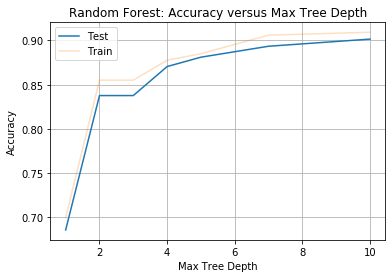

In [22]:
plt.figure()
plt.plot(list(scores_rf.keys()), [scores_rf[md][0] for md in scores_rf], label='Test')
plt.plot(list(scores_rf.keys()), [scores_rf[md][1] for md in scores_rf], label='Train', alpha=0.25)
plt.title('Random Forest: Accuracy versus Max Tree Depth')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

### AdaBoost

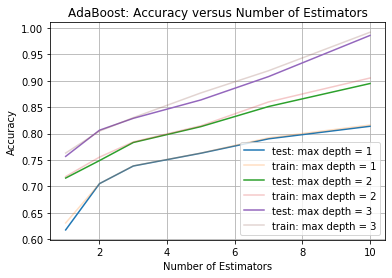

In [23]:
max_depths, ys = get_param_data(scores_adaboost)

plt.figure()
for max_depth,dictionary in zip(max_depths,ys):
    plt.plot(list(dictionary.keys()), [dictionary[md][0] for md in dictionary], label='test: max depth = '+str(max_depth))
    plt.plot(list(dictionary.keys()), [dictionary[md][1] for md in dictionary], label='train: max depth = '+str(max_depth), alpha=0.25)
plt.title('AdaBoost: Accuracy versus Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

### Neural Network

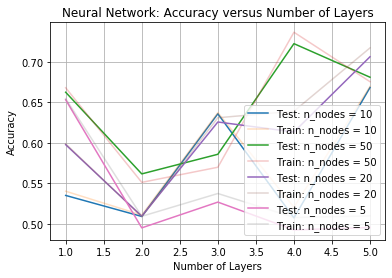

In [24]:
max_depths, ys = get_param_data(scores_nn)

plt.figure()
for max_depth,dictionary in zip(max_depths,ys):
    plt.plot(list(dictionary.keys()), [dictionary[md][0] for md in dictionary], label='Test: n_nodes = '+str(max_depth))
    plt.plot(list(dictionary.keys()), [dictionary[md][1] for md in dictionary], label='Train: n_nodes = '+str(max_depth), alpha=0.25)
plt.title('Neural Network: Accuracy versus Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Logistic Regression

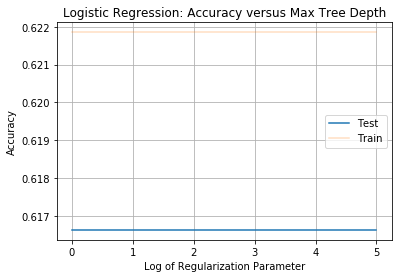

In [25]:
plt.figure()
plt.plot([np.log(c+1) for c in list(scores_lr.keys())], [scores_lr[md][0] for md in scores_lr], label='Test')
plt.plot([np.log(c+1) for c in list(scores_lr.keys())], [scores_lr[md][1] for md in scores_lr], label='Train', alpha=0.25)
plt.title('Logistic Regression: Accuracy versus Max Tree Depth')
plt.xlabel('Log of Regularization Parameter')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

### XGBoost

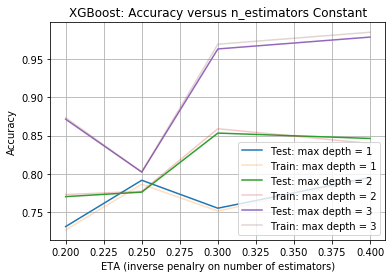

In [26]:
max_depths, ys = get_param_data(scores_xgb)

plt.figure()
for max_depth,dictionary in zip(max_depths,ys):
    plt.plot(list(dictionary.keys()), [dictionary[md][0] for md in dictionary], label='Test: max depth = '+str(max_depth))
    plt.plot(list(dictionary.keys()), [dictionary[md][1] for md in dictionary], label='Train: max depth = '+str(max_depth), alpha=0.25)
plt.title('XGBoost: Accuracy versus n_estimators Constant')
plt.xlabel('ETA (inverse penalry on number of estimators)')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show()

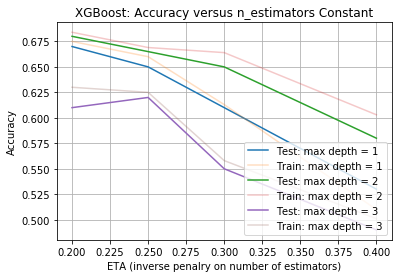

In [27]:
etas = [0.20, 0.25, 0.30, 0.40]

plt.figure()

plt.plot(etas, [0.67, 0.65, 0.61, 0.53], label='Test: max depth = 1')
plt.plot(etas, [0.675, 0.66, 0.613, 0.51], label='Train: max depth = 1', alpha=0.25)
plt.plot(etas, [0.68, 0.665, 0.65, 0.58], label='Test: max depth = 2')
plt.plot(etas, [0.684, 0.669, 0.664, 0.603], label='Train: max depth = 2', alpha=0.25)
plt.plot(etas, [0.61, 0.62, 0.55, 0.49], label='Test: max depth = 3')
plt.plot(etas, [0.63, 0.625, 0.558, 0.501], label='Train: max depth = 3', alpha=0.25)

plt.title('XGBoost: Accuracy versus n_estimators Constant')
plt.xlabel('ETA (inverse penalry on number of estimators)')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot Predictions on VIX Data using Optimal Parameters

In [32]:
# X_test = X_test_all.drop('index', axis = 1).copy()
# X_train = X_train_all.drop('index', axis = 1).copy()
X_test = X_test_all.copy()
X_train = X_train_all.copy()
y_test = y_test_all.copy()
y_train = y_train_all.copy()

In [33]:
# ### Optimal Parameters for Random Forest
max_tree_depth_rf = 3
model_rf = rf(max_depth=max_tree_depth_rf).fit(X_train, y_train)
c_m_rf = confusion_matrix(y_test, model_rf.predict(X_test))

# ### Optimal Parameters for AdaBoost
max_tree_depth_adaboost = 1
n_estiators_adaboost = 3
model_ab = ab(base_estimator=DecisionTreeClassifier(max_depth=max_tree_depth_adaboost), n_estimators=n_estiators_adaboost).fit(X_train, y_train)
c_m_ab = confusion_matrix(y_test, model_ab.predict(X_test))

# ### Optimal Parameters for Neural Network
architecture_nn = [5, 5, 5]
model_nn = nn(hidden_layer_sizes=architecture_nn).fit(X_train, y_train)
c_m_nn = confusion_matrix(y_test, model_nn.predict(X_test))

# ### Optimal Parameters for Logistic Regression
c_lr = 1.0
model_lr = lr(C=c_lr, solver='lbfgs').fit(X_train, y_train)
c_m_lr = confusion_matrix(y_test, model_lr.predict(X_test))

### Optimal Parameters for XGBoost
max_depth_xgb = 1
eta_xgb = 0.2
param = {'max_depth': max_depth_xgb,'eta': eta_xgb,'silent': 1,'objective': 'multi:softprob','num_class': 2}
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
num_round = 200
model_xgb = xgb.train(param, dtrain, num_round, evals= [(dtrain, 'train')], early_stopping_rounds=3, verbose_eval=20)
preds = np.round(model_xgb.predict(dtest)[:,1]).astype(int)
c_m_xgb = confusion_matrix(y_test, preds)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-merror:0.344893
Will train until train-merror hasn't improved in 3 rounds.
Stopping. Best iteration:
[11]	train-merror:0.261599



Feature ranking:


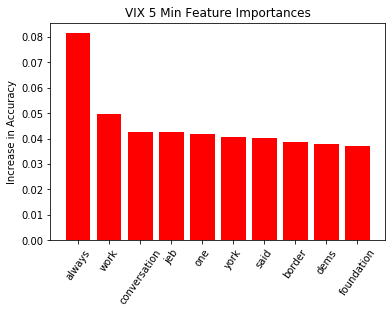

In [34]:
### plot feature importances (random forest)
n_features = 10

importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# for f in range(len(importances)):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("VIX "+str(time_frame)+" Min Feature Importances")
plt.bar(range(n_features), importances[indices[0:n_features]], color="r", align="center")
plt.xticks(range(n_features), X_train.columns[indices[0:n_features]], rotation=55)
plt.ylabel('Increase in Accuracy')
plt.show()

[('retweet_count', 0.1906740550389527), ('favorite_count', 0.1502585999669243), ('new', 0.09767651003850161), ('francis', 0.09682488552579128), ('trump', 0.09502866953981398), ('news', 0.08274709401448713), ('get', 0.07892204742862874), ('democrats', 0.07306341488594524), ('cuomo', 0.07160900831639376), ('amazing', 0.06319571524456147)]


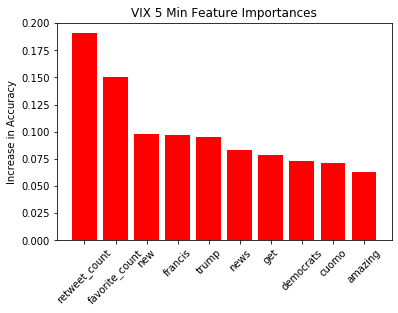

In [35]:
### plot feature importances (XGBoost)

importances = model_xgb.get_score(importance_type='gain')
total_importance = sum([importances[key] for key in importances])
importances = [(feature,importance/total_importance) for feature,importance in sorted(zip([key for key in importances],[importances[key] for key in importances]), key = lambda x: x[1], reverse=True)][0:10]
print(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("VIX 5 Min Feature Importances")
plt.bar(range(10), [importance for x,importance in importances], color="r", align="center")
plt.xticks(range(10), [feature for feature,x in importances], rotation=45)
plt.ylabel('Increase in Accuracy')
plt.show()

<Figure size 432x288 with 0 Axes>

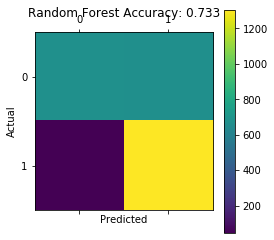

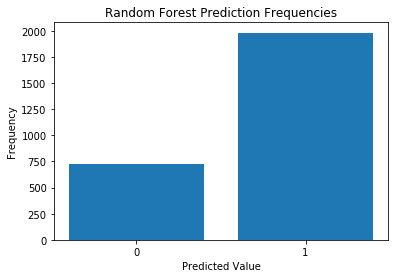

<Figure size 432x288 with 0 Axes>

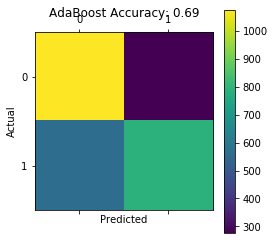

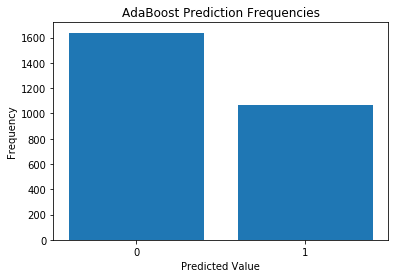

<Figure size 432x288 with 0 Axes>

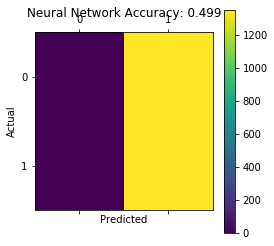

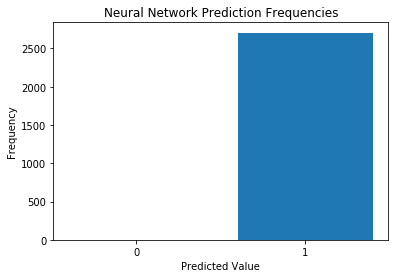

<Figure size 432x288 with 0 Axes>

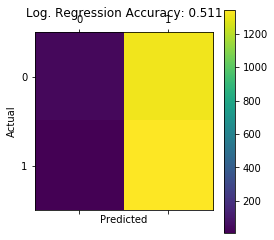

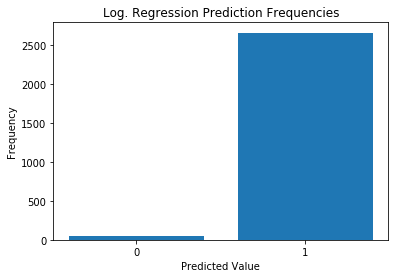

<Figure size 432x288 with 0 Axes>

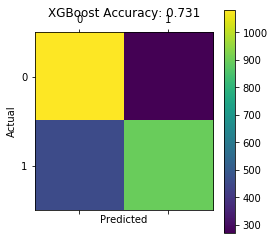

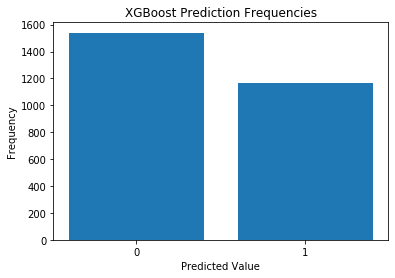

In [36]:
### Plot Barplot

plt.figure()
plt.matshow(c_m_rf)
plt.title('Random Forest Accuracy: '+str(round((c_m_rf[0,0]+c_m_rf[1,1])/sum(sum(c_m_rf)),3)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()
plt.figure()
plt.bar([0,1],[sum(c_m_rf[:,0]),sum(c_m_rf[:,1])])
plt.title('Random Forest Prediction Frequencies')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.xticks([0,1])
plt.show()

plt.figure()
plt.matshow(c_m_ab)
plt.title('AdaBoost Accuracy: '+str(round((c_m_ab[0,0]+c_m_ab[1,1])/sum(sum(c_m_ab)),3)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()
plt.figure()
plt.bar([0,1],[sum(c_m_ab[:,0]),sum(c_m_ab[:,1])])
plt.title('AdaBoost Prediction Frequencies')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.xticks([0,1])
plt.show()

plt.figure()
plt.matshow(c_m_nn)
plt.title('Neural Network Accuracy: '+str(round((c_m_nn[0,0]+c_m_nn[1,1])/sum(sum(c_m_nn)),3)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()
plt.figure()
plt.bar([0,1],[sum(c_m_nn[:,0]),sum(c_m_nn[:,1])])
plt.title('Neural Network Prediction Frequencies')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.xticks([0,1])
plt.show()

plt.figure()
plt.matshow(c_m_lr)
plt.title('Log. Regression Accuracy: '+str(round((c_m_lr[0,0]+c_m_lr[1,1])/sum(sum(c_m_lr)),3)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()
plt.figure()
plt.bar([0,1],[sum(c_m_lr[:,0]),sum(c_m_lr[:,1])])
plt.title('Log. Regression Prediction Frequencies')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.xticks([0,1])
plt.show()

plt.figure()
plt.matshow(c_m_xgb)
plt.title('XGBoost Accuracy: '+str(round((c_m_xgb[0,0]+c_m_xgb[1,1])/sum(sum(c_m_xgb)),3)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()
plt.figure()
plt.bar([0,1],[sum(c_m_xgb[:,0]),sum(c_m_xgb[:,1])])
plt.title('XGBoost Prediction Frequencies')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.xticks([0,1])
plt.show()

# Regression – VIX

In [37]:
tweets_vix_df = trump_vix_df_timeframe(1)

v_all = TfidfVectorizer()
X_all = v_all.fit_transform(tweets_vix_df['text'])
df_tfidf_all = pd.DataFrame(X_all.toarray(), columns=v_all.get_feature_names())
tweets_all_subset = tweets_vix_df[['retweet_count', 'favorite_count']]
all_data = pd.concat([tweets_all_subset.reset_index(), df_tfidf_all], axis=1)

all_data['perc_change'] = tweets_vix_df['perc_change'].tolist()
all_data = all_data.drop('index', axis = 1)
all_data = all_data.dropna()

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(all_data.loc[:, all_data.columns != 'perc_change'], 
                                                     all_data.perc_change, test_size=0.3, 
                                                     random_state = 109)

dmatrix_train = xgb.DMatrix(data=X_train_all,label=y_train_all)
dmatrix_test = xgb.DMatrix(data=X_test_all,label=y_test_all)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [38]:
### Random Forest Regression
from  sklearn.ensemble import RandomForestRegressor as rf_reg

max_depths = [1,2,3,5,10,25,35,50,75,100]
scores_rf_reg = dict()

for max_depth in max_depths:
    print('Testing Max Depth',max_depth,end='')
    start = time.time()
    kf = KFold(n_splits=5)
    
    accuracies = list()
    for train_index, test_index in kf.split(X_train_all.values):
        rf_model_all = rf_reg(n_estimators=100, max_depth=max_depth, max_features = 'sqrt').fit(X_train_all.values[train_index], y_train_all.values[train_index])
        preds = rf_model_all.predict(X_train_all.values[test_index])
        random_forest_test_score_all = np.mean((y_train_all.values[test_index] - preds)**2)
        accuracies.append(random_forest_test_score_all)
    scores_rf_reg[max_depth] = np.mean(accuracies)
    print(' ...',round(time.time()-start,1),'seconds elapsed')

Testing Max Depth 1 ... 4.5 seconds elapsed
Testing Max Depth 2 ... 5.6 seconds elapsed
Testing Max Depth 3 ... 6.1 seconds elapsed
Testing Max Depth 5 ... 7.4 seconds elapsed
Testing Max Depth 10 ... 11.8 seconds elapsed
Testing Max Depth 25 ... 23.4 seconds elapsed
Testing Max Depth 35 ... 33.3 seconds elapsed
Testing Max Depth 50 ... 41.9 seconds elapsed
Testing Max Depth 75 ... 55.4 seconds elapsed
Testing Max Depth 100 ... 66.6 seconds elapsed


In [39]:
for max_depth in scores_rf_reg:
    print(max_depth,':\t', scores_rf_reg[max_depth])

1 :	 6.856532902228257e-06
2 :	 6.85874350947167e-06
3 :	 6.853043805992583e-06
5 :	 6.865308178645032e-06
10 :	 6.879718010492483e-06
25 :	 6.9604108961948794e-06
35 :	 6.9829743270681205e-06
50 :	 7.054145410504754e-06
75 :	 7.137894849095361e-06
100 :	 7.225260559912452e-06


In [40]:
model_rf_reg = rf_reg(n_estimators=200, max_depth=3, max_features = 'sqrt').fit(X_train_all, y_train_all)
preds = model_rf_reg.predict(X_test_all)

baseline_mse = np.mean((y_test_all.values-np.mean(y_train_all))**2)
rf_mse = np.mean((preds - y_test_all)**2)

print('Baseline prediction MSE:',baseline_mse)
print('Random forest prediction MSE:',rf_mse)

Baseline prediction MSE: 6.879661019152236e-06
Random forest prediction MSE: 6.873156884782908e-06


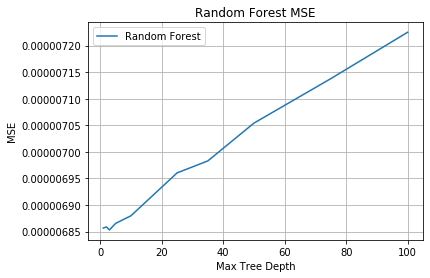

In [41]:
### Plot mse versus max tree depth
plt.figure()
plt.plot([key for key in scores_rf_reg.keys()], [scores_rf_reg[key] for key in scores_rf_reg], label='Random Forest')
# plt.axhline(y=baseline_mse, label='Predicting Mean (Baseline)')
plt.xlabel('Max Tree Depth')
plt.ylabel('MSE')
plt.title('Random Forest MSE')
plt.legend()
plt.grid()
plt.show()

# S&P SECTION

## Dataset Reconciliation – S&P

In [42]:
### define prediction time frame in minutes -- change to 'time_frame = 1' to predict at the 1-minute level
time_frame = 5

In [43]:
sp_df = pd.read_csv("tf_data/ES_intraday.txt", sep = ",")
trump_tweets_df = pd.read_csv("tf_data/tweets_trump.csv")

# remove retweets
trump_tweets_df = trump_tweets_df[trump_tweets_df['is_retweet'] == False]
string_manipulation(trump_tweets_df, 'text')


trump_tweets_df['created_at'] = pd.to_datetime(trump_tweets_df['created_at'])
trump_tweets_df['time_stamp'] = list(map(lambda x : str(x)[:5], trump_tweets_df['created_at'].dt.time.tolist()))
trump_tweets_df['date'] = list(map(lambda x : str(x)[5:7] + "/" + str(x)[8:10] + "/" + str(x)[:4], 
                                   trump_tweets_df['created_at'].dt.date.tolist()))


# reconcile S&P and Trump tweets datasets by date and time
trump_tweets_df_biz = trump_tweets_df[trump_tweets_df['date'].isin(sp_df['Date'])]
trump_tweets_df_biz = trump_tweets_df_biz[trump_tweets_df_biz['time_stamp'].isin(sp_df['Time'])]

# merging S&P and Trump tweets datasets
tweets_sp_df = pd.merge(trump_tweets_df_biz, sp_df,  how='left', left_on=['date','time_stamp'], 
                  right_on = ['Date','Time']).dropna()
tweets_sp_df = tweets_sp_df.drop(['id_str', 'date', 'time_stamp'], axis = 1)

def get_perc_change_after_time(num_minutes_after_tweet):
    import datetime
    
    next_min_list = list(map(lambda x: str((datetime.datetime.combine(datetime.date(1, 1, 1), x) + datetime.timedelta(minutes=num_minutes_after_tweet)).time())[:5], 
                             tweets_sp_df['created_at'].dt.time.tolist()))
    curr_min_list = tweets_sp_df['Time']
    date_list = tweets_sp_df['Date'].tolist()
    
    spliced_min = [None]*(len(next_min_list)+len(curr_min_list))
    spliced_min[::2] = curr_min_list
    spliced_min[1::2] = next_min_list

    spliced_date = [None]*(len(date_list)+len(date_list))
    spliced_date[::2] = date_list
    spliced_date[1::2] = date_list
    
    df_dict = {}
    df_dict['date'] = spliced_date
    df_dict['time'] = spliced_min
    
    spliced_df = pd.DataFrame(df_dict)
    
    spliced_merge = pd.merge(spliced_df, sp_df,  how='left', left_on=['date','time'], 
                  right_on = ['Date','Time'])
    
    perc_change_list = spliced_merge['Open'].pct_change().tolist()[1:][::2]
    
    return perc_change_list

def trump_sp_df_timeframe(num_minutes_after_tweet):
    tweets_sp_df['perc_change'] = get_perc_change_after_time(num_minutes_after_tweet)
    tweets_sp_df['change_ind'] = list(map(lambda x: 1 if x > 0 else 0, get_perc_change_after_time(num_minutes_after_tweet)))
    return tweets_sp_df

tweets_sp_df = trump_sp_df_timeframe(time_frame)

v_all = TfidfVectorizer()
X_all = v_all.fit_transform(tweets_sp_df['text'])
df_tfidf_all = pd.DataFrame(X_all.toarray(), columns=v_all.get_feature_names())
tweets_all_subset = tweets_sp_df[['retweet_count', 'favorite_count']]
all_data = pd.concat([tweets_all_subset.reset_index(), df_tfidf_all], axis=1)

all_data['change_ind'] = tweets_sp_df['change_ind'].tolist()

### normalize number of samples in dataset
from sklearn.utils import resample
zero_data = all_data.loc[all_data['change_ind']==0]
one_data = all_data.loc[all_data['change_ind']==1]
n_samples = max(len(zero_data), len(one_data))
zero_data = resample(zero_data, replace=True, n_samples=n_samples)
one_data = resample(one_data, replace=True, n_samples=n_samples)
all_data = pd.concat([zero_data,one_data])

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(all_data.loc[:, all_data.columns != 'change_ind'], 
                                                     all_data.change_ind, test_size=0.3, 
                                                     random_state = 109, 
                                                     stratify = all_data.change_ind)

# Find Optimal Parameters for the 4 Models

In [44]:
X = X_train_all.copy()
X = X.reset_index(drop=True)
Y = y_train_all.copy()
Y = Y.reset_index(drop=True)

### Random Forest

In [45]:
### parameters to search: max_depth

max_depths = [1,2,3,5,10,25,35,50,75,100]
scores_rf = dict()

for max_depth in max_depths:
    print('Testing Max Depth',max_depth,end='')
    start = time.time()
    kf = KFold(n_splits=2)
    
    accuracies_train = list()
    accuracies_test = list()
    for train_index, test_index in kf.split(X):
        rf_model_all = rf(n_estimators=58, max_depth=max_depth, max_features = 'sqrt').fit(X.iloc[train_index], Y.iloc[train_index])
        preds = rf_model_all.predict(X.iloc[test_index])# predict on test data
        preds_train = rf_model_all.predict(X.iloc[train_index])# predict on train data
        score_test = accuracy_score(Y.iloc[test_index], preds)# get test accuracy
        score_train = accuracy_score(Y.iloc[train_index], preds_train)# get train accuracy
        accuracies_train.append(score_train)
        accuracies_test.append(score_test)
    scores_rf[max_depth] = (np.mean(accuracies_test), np.mean(accuracies_train))
    print(' ...',round(time.time()-start,1),'seconds elapsed')

Testing Max Depth 1 ... 2.3 seconds elapsed
Testing Max Depth 2 ... 2.3 seconds elapsed
Testing Max Depth 3 ... 2.2 seconds elapsed
Testing Max Depth 5 ... 2.0 seconds elapsed
Testing Max Depth 10 ... 2.8 seconds elapsed
Testing Max Depth 25 ... 4.1 seconds elapsed
Testing Max Depth 35 ... 6.4 seconds elapsed
Testing Max Depth 50 ... 5.3 seconds elapsed
Testing Max Depth 75 ... 7.1 seconds elapsed
Testing Max Depth 100 ... 8.2 seconds elapsed


In [46]:
for params in scores_rf:
    print(params,scores_rf[params])

1 (0.5162544025808743, 0.5633780744073165)
2 (0.526446710273182, 0.6047316275490573)
3 (0.5568376890520023, 0.6695504927930861)
5 (0.5589528516885192, 0.7164862225116169)
10 (0.5924234172906739, 0.8109253559061178)
25 (0.6276206825110249, 0.9072908219137538)
35 (0.6437790422351792, 0.933832909107053)
50 (0.6503170598159056, 0.9565302483203599)
75 (0.6664751235682362, 0.9732636812975405)
100 (0.6695524166099387, 0.9836514043863025)


### AdaBoost

In [47]:
max_depths = [1,2,3]
n_estimators = [1,2,5,10,30,50,100]
scores_adaboost = dict()

for max_depth in max_depths:
    for n_estimator in n_estimators:
        print('Testing Max Depth',max_depth,'and n_estimator',n_estimator,end='')
        start = time.time()
        kf = KFold(n_splits=2)

        accuracies_train = list()
        accuracies_test = list()
        for train_index, test_index in kf.split(X):
            model = ab(base_estimator=DecisionTreeClassifier(max_depth=max_depth), n_estimators=n_estimator).fit(X.iloc[train_index], Y.iloc[train_index])
            preds = model.predict(X.iloc[test_index])# predict on test data
            preds_train = model.predict(X.iloc[train_index])# predict on train data
            score_test = accuracy_score(Y.iloc[test_index], preds)# get test accuracy
            score_train = accuracy_score(Y.iloc[train_index], preds_train)# get train accuracy
            accuracies_train.append(score_train)
            accuracies_test.append(score_test)
        scores_adaboost[(max_depth, n_estimator)] = (np.mean(accuracies_test), np.mean(accuracies_train))
        print(' ...',round(time.time()-start,1),'seconds elapsed')

Testing Max Depth 1 and n_estimator 1 ... 1.9 seconds elapsed
Testing Max Depth 1 and n_estimator 2 ... 2.3 seconds elapsed
Testing Max Depth 1 and n_estimator 5 ... 3.7 seconds elapsed
Testing Max Depth 1 and n_estimator 10 ... 6.1 seconds elapsed
Testing Max Depth 1 and n_estimator 30 ... 15.3 seconds elapsed
Testing Max Depth 1 and n_estimator 50 ... 26.7 seconds elapsed
Testing Max Depth 1 and n_estimator 100 ... 53.2 seconds elapsed
Testing Max Depth 2 and n_estimator 1 ... 2.2 seconds elapsed
Testing Max Depth 2 and n_estimator 2 ... 2.8 seconds elapsed
Testing Max Depth 2 and n_estimator 5 ... 4.2 seconds elapsed
Testing Max Depth 2 and n_estimator 10 ... 6.9 seconds elapsed
Testing Max Depth 2 and n_estimator 30 ... 18.0 seconds elapsed
Testing Max Depth 2 and n_estimator 50 ... 30.0 seconds elapsed
Testing Max Depth 2 and n_estimator 100 ... 59.3 seconds elapsed
Testing Max Depth 3 and n_estimator 1 ... 2.0 seconds elapsed
Testing Max Depth 3 and n_estimator 2 ... 2.7 seconds 

In [48]:
for params in scores_adaboost:
    print(params,scores_adaboost[params])

(1, 1) (0.5097115014650605, 0.5279895373960399)
(1, 2) (0.5085576553112143, 0.5295285908781484)
(1, 5) (0.5122123153875751, 0.5391458993103857)
(1, 10) (0.5164439725338148, 0.5606874685529937)
(1, 30) (0.5345268150472076, 0.6108876194986237)
(1, 50) (0.5466447894160475, 0.6443553733684553)
(1, 100) (0.572418237783763, 0.7168692100512031)
(2, 1) (0.5110576553112144, 0.5376085476662622)
(2, 2) (0.5114424926746974, 0.5429942729452156)
(2, 5) (0.5150974487228815, 0.564535768194868)
(2, 10) (0.5199062509249119, 0.5883865835972415)
(2, 30) (0.5568368011365318, 0.6826328913487436)
(2, 50) (0.5758794062805221, 0.7457203954183562)
(2, 100) (0.6097330334152189, 0.8607413354248676)
(3, 1) (0.5150973747299257, 0.5476097315535561)
(3, 2) (0.5179822860863645, 0.5635734898037708)
(3, 5) (0.5266381300500192, 0.5901166128984521)
(3, 10) (0.5479896853819517, 0.6401236422292598)
(3, 30) (0.5851095095746885, 0.7593803089945836)
(3, 50) (0.6118472341433095, 0.8351616746085773)
(3, 100) (0.655895536744902, 

### Neural Network

In [49]:
architectures = [(5, ) , (10,) , (25,) , (100,) , (200,) , (5,5) , (10,5) , (25,5) , (100,5) , (200,5) , (5,10) , (10,10) , (25,10) , (100,10) , (200,10) , (5,25) , (10,25) , (25,25) , (100,25) , (200,25) , (5,100) , (10,100) , (25,100) , (100,100) , (200,100) , (5,200) , (10,200) , (25,200) , (100,200) , (200,200)]
scores_nn = dict()

nodess = [5,10,20,50]
layerss = [1,2,3,4,5]

for nodes in nodess:
    for layers in layerss:
        architecture = [int(num) for num in list(nodes*np.ones(layers))]
        print('Testing Architecture:',architecture,end='')
        start = time.time()
        kf = KFold(n_splits=2)

        accuracies_train = list()
        accuracies_test = list()
        for train_index, test_index in kf.split(X):
            model  = nn(hidden_layer_sizes=architecture).fit(X.iloc[train_index], Y.iloc[train_index])
            preds = model.predict(X.iloc[test_index])# predict on test data
            preds_train = model.predict(X.iloc[train_index])# predict on train data
            score_test = accuracy_score(Y.iloc[test_index], preds)# get test accuracy
            score_train = accuracy_score(Y.iloc[train_index], preds_train)# get train accuracy
            accuracies_train.append(score_train)
            accuracies_test.append(score_test)
        scores_nn[(nodes, layers)] = (np.mean(accuracies_test), np.mean(accuracies_train))
        print(' ...',round(time.time()-start,1),'seconds elapsed')

Testing Architecture: [5] ... 47.1 seconds elapsed
Testing Architecture: [5, 5] ... 15.6 seconds elapsed
Testing Architecture: [5, 5, 5] ... 8.5 seconds elapsed
Testing Architecture: [5, 5, 5, 5] ... 16.0 seconds elapsed
Testing Architecture: [5, 5, 5, 5, 5] ... 17.2 seconds elapsed
Testing Architecture: [10] ... 45.7 seconds elapsed
Testing Architecture: [10, 10] ... 11.9 seconds elapsed
Testing Architecture: [10, 10, 10] ... 14.9 seconds elapsed
Testing Architecture: [10, 10, 10, 10] ... 17.0 seconds elapsed
Testing Architecture: [10, 10, 10, 10, 10] ... 12.6 seconds elapsed
Testing Architecture: [20] ... 48.1 seconds elapsed
Testing Architecture: [20, 20] ... 32.2 seconds elapsed
Testing Architecture: [20, 20, 20] ... 13.9 seconds elapsed
Testing Architecture: [20, 20, 20, 20] ... 14.1 seconds elapsed
Testing Architecture: [20, 20, 20, 20, 20] ... 17.8 seconds elapsed
Testing Architecture: [50]

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


 ... 127.3 seconds elapsed
Testing Architecture: [50, 50] ... 40.5 seconds elapsed
Testing Architecture: [50, 50, 50] ... 19.6 seconds elapsed
Testing Architecture: [50, 50, 50, 50] ... 32.4 seconds elapsed
Testing Architecture: [50, 50, 50, 50, 50] ... 28.7 seconds elapsed


In [50]:
for params in scores_nn:
    print(params,scores_nn[params])

(5, 1) (0.4966338384585787, 0.5047126113593986)
(5, 2) (0.5010569153816556, 0.5012497410246545)
(5, 3) (0.49951845384319415, 0.49990306922780947)
(5, 4) (0.49644153076627107, 0.5043278479888714)
(5, 5) (0.5006740018350253, 0.5006738538491136)
(10, 1) (0.5049050670376181, 0.5000953769201172)
(10, 2) (0.528941530766271, 0.620718767573327)
(10, 3) (0.49971068754254594, 0.5002876846124249)
(10, 4) (0.5200996685115578, 0.5233682333441856)
(10, 5) (0.5035569153816557, 0.5118307337141503)
(20, 1) (0.5050970787581022, 0.4981728179477314)
(20, 2) (0.5112544765738302, 0.5247130553171337)
(20, 3) (0.5024032912066771, 0.5139465622872703)
(20, 4) (0.5018268120874892, 0.5025953029271613)
(20, 5) (0.5081723739899962, 0.523372598928582)
(50, 1) (0.5022111315002812, 0.5077884985349395)
(50, 2) (0.5047126113593986, 0.49798006629768843)
(50, 3) (0.5045200076952674, 0.4979802142836002)
(50, 4) (0.5037497410246544, 0.5137533666794921)
(50, 5) (0.5022124633734868, 0.5251048480184686)


### Logistic Regression

In [51]:
regularization_params = [np.exp(p)-1 for p in np.linspace(0.001,5,21)]
scores_lr = dict()

for i,c in enumerate(regularization_params):
    print(i,'/',(len(regularization_params)-1),': Testing Regularization Parameter c =',round(c,2),end='')
    start = time.time()
    kf = KFold(n_splits=2)

    accuracies_train = list()
    accuracies_test = list()
    for train_index, test_index in kf.split(X):
        model  = lr(C=c, solver='lbfgs').fit(X.iloc[train_index], Y.iloc[train_index])
        preds = model.predict(X.iloc[test_index])# predict on test data
        preds_train = model.predict(X.iloc[train_index])# predict on train data
        score_test = accuracy_score(Y.iloc[test_index], preds)# get test accuracy
        score_train = accuracy_score(Y.iloc[train_index], preds_train)# get train accuracy
        accuracies_train.append(score_train)
        accuracies_test.append(score_test)
    scores_lr[c] = (np.mean(accuracies_test), np.mean(accuracies_train))
    print(' ...',round(time.time()-start,1),'seconds elapsed')

0 / 20 : Testing Regularization Parameter c = 0.0 ... 2.8 seconds elapsed
1 / 20 : Testing Regularization Parameter c = 0.29 ... 2.9 seconds elapsed
2 / 20 : Testing Regularization Parameter c = 0.65 ... 2.8 seconds elapsed
3 / 20 : Testing Regularization Parameter c = 1.12 ... 2.9 seconds elapsed
4 / 20 : Testing Regularization Parameter c = 1.72 ... 2.8 seconds elapsed
5 / 20 : Testing Regularization Parameter c = 2.49 ... 2.8 seconds elapsed
6 / 20 : Testing Regularization Parameter c = 3.48 ... 2.7 seconds elapsed
7 / 20 : Testing Regularization Parameter c = 4.76 ... 2.8 seconds elapsed
8 / 20 : Testing Regularization Parameter c = 6.39 ... 2.7 seconds elapsed
9 / 20 : Testing Regularization Parameter c = 8.49 ... 2.8 seconds elapsed
10 / 20 : Testing Regularization Parameter c = 11.19 ... 2.8 seconds elapsed
11 / 20 : Testing Regularization Parameter c = 14.65 ... 2.7 seconds elapsed
12 / 20 : Testing Regularization Parameter c = 19.09 ... 2.8 seconds elapsed
13 / 20 : Testing Re

In [52]:
for params in scores_lr:
    print(params,scores_lr[params])

0.0010005001667083846 (0.509906768875603, 0.5218319915944003)
0.2852458204335895 (0.509906768875603, 0.5218319915944003)
0.6502057877762375 (0.509906768875603, 0.5218319915944003)
1.118800231609781 (0.509906768875603, 0.5218319915944003)
1.7204573240040038 (0.509906768875603, 0.5218319915944003)
2.492961696584355 (0.509906768875603, 0.5218319915944003)
3.484827350957371 (0.509906768875603, 0.5218319915944003)
4.758344383668384 (0.509906768875603, 0.5218319915944003)
6.393490862886152 (0.509906768875603, 0.5218319915944003)
8.492955526351688 (0.509906768875603, 0.5218319915944003)
11.188586730749401 (0.509906768875603, 0.5218319915944003)
14.649672652590132 (0.509906768875603, 0.5218319915944003)
19.093572745014153 (0.509906768875603, 0.5218319915944003)
24.7993681160067 (0.509906768875603, 0.5218319915944003)
32.125388084624284 (0.509906768875603, 0.5218319915944003)
41.531713599457326 (0.509906768875603, 0.5218319915944003)
53.60907075518664 (0.509906768875603, 0.5218319915944003)
69.

### XGBoost

In [53]:
len(preds_train), len(y_train_all)

(2600, 5199)

In [54]:
# Create the training and test data
try:
    X_train_all = X_train_all.drop('index', axis = 1)
    X_test_all = X_test_all.drop('index', axis = 1)
except:
    pass
dtrain = xgb.DMatrix(X_train_all, label=y_train_all)
dtest = xgb.DMatrix(X_test_all, label=y_test_all)

# Number of training iterations
num_round = 200  


max_depths = [1,2,3]
etas = [0.2,0.25,0.3,0.4]
scores_xgb = dict()
for max_depth in max_depths:
    for eta in etas:
        print('Testing Max Depth =',max_depth,'and eta =',eta)
        param = {
            'max_depth': max_depth,         # the maximum depth of each tree
            'eta': eta,                     # the training step for each iteration
            'silent': 1,                    # logging mode - quiet
            'objective': 'multi:softprob',  # error evaluation for multiclass training
            'num_class': 2}                 # the number of classes that exist in this datset
        start = time.time()
        model = xgb.train(param, 
            dtrain, 
            num_round, 
            evals= [(dtrain, 'train')], 
            early_stopping_rounds=3,
            verbose_eval=20)

        preds = model.predict(dtest)
        preds = np.asarray([np.argmax(line) for line in preds])
        preds_train = model.predict(dtrain)
        preds_train = np.asarray([np.argmax(line) for line in preds_train])
        score_test = accuracy_score(y_test_all, preds)# get test accuracy
        score_train = accuracy_score(y_train_all, preds_train)# get train accuracy
        scores_xgb[(max_depth,eta)] = (score_test, score_train)
        
        print(' ...',round(time.time()-start,1),'seconds elapsed')

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Testing Max Depth = 1 and eta = 0.2
[0]	train-merror:0.494711
Will train until train-merror hasn't improved in 3 rounds.
[20]	train-merror:0.446817
Stopping. Best iteration:
[24]	train-merror:0.440662

 ... 63.1 seconds elapsed
Testing Max Depth = 1 and eta = 0.25
[0]	train-merror:0.494711
Will train until train-merror hasn't improved in 3 rounds.
[20]	train-merror:0.446817
Stopping. Best iteration:
[24]	train-merror:0.440662

 ... 60.9 seconds elapsed
Testing Max Depth = 1 and eta = 0.3
[0]	train-merror:0.494711
Will train until train-merror hasn't improved in 3 rounds.
[20]	train-merror:0.448932
Stopping. Best iteration:
[19]	train-merror:0.44874

 ... 50.6 seconds elapsed
Testing Max Depth = 1 and eta = 0.4
[0]	train-merror:0.494711
Will train until train-merror hasn't improved in 3 rounds.
[20]	train-merror:0.448932
Stopping. Best iteration:
[18]	train-merror:0.448932

 ... 50.5 seconds elapsed
Testing Max Depth = 2 and eta = 0.2
[0]	train-merror:0.48567
Will train until train-merr

In [55]:
for param in scores_xgb:
    print(param,scores_xgb[param])

(1, 0.2) (0.5352175863615971, 0.5593383342950567)
(1, 0.25) (0.5352175863615971, 0.5593383342950567)
(1, 0.3) (0.5329744279946165, 0.5510675129832661)
(1, 0.4) (0.5334230596680125, 0.5510675129832661)
(2, 0.2) (0.6020637056976222, 0.6809001731102136)
(2, 0.25) (0.633019291161956, 0.742065781881131)
(2, 0.3) (0.6523104531179902, 0.7936141565685709)
(2, 0.4) (0.5688649618663078, 0.6341604154645124)
(3, 0.2) (0.6648721399730821, 0.8199653779572995)
(3, 0.25) (0.6882009869896815, 0.858819003654549)
(3, 0.3) (0.6832660385823239, 0.8697826505097134)
(3, 0.4) (0.7133243606998654, 0.8928640123100596)


# Graph Optimal Parameters

### Random Forest

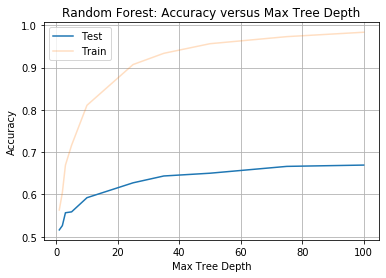

In [56]:
plt.figure()
plt.plot(list(scores_rf.keys()), [scores_rf[md][0] for md in scores_rf], label='Test')
plt.plot(list(scores_rf.keys()), [scores_rf[md][1] for md in scores_rf], label='Train', alpha=0.25)
plt.title('Random Forest: Accuracy versus Max Tree Depth')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

### AdaBoost

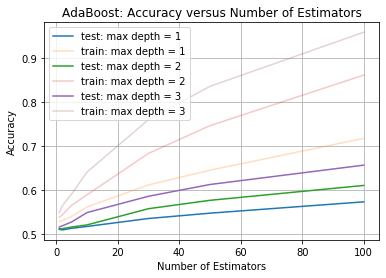

In [57]:
def get_param_data(scores):
    ys = list()
    max_depths = set()
    for item in scores:
        max_depths.add(item[0])
    max_depths = list(max_depths)
    for max_depth in max_depths:
        max_depth_dict = dict()
        for item in scores:
            if item[0]==max_depth:
                if len(item) == 2:
                    max_depth_dict[item[1]] = scores[item]
                else:
                    max_depth_dict[0] = scores[item]
        ys.append(max_depth_dict)
    return max_depths, ys

max_depths, ys = get_param_data(scores_adaboost)

plt.figure()
for max_depth,dictionary in zip(max_depths,ys):
    plt.plot(list(dictionary.keys()), [dictionary[md][0] for md in dictionary], label='test: max depth = '+str(max_depth))
    plt.plot(list(dictionary.keys()), [dictionary[md][1] for md in dictionary], label='train: max depth = '+str(max_depth), alpha=0.25)
plt.title('AdaBoost: Accuracy versus Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

### Neural Network

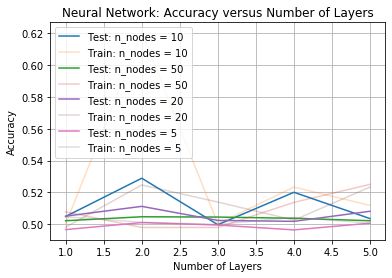

In [58]:
max_depths, ys = get_param_data(scores_nn)

plt.figure()
for max_depth,dictionary in zip(max_depths,ys):
    plt.plot(list(dictionary.keys()), [dictionary[md][0] for md in dictionary], label='Test: n_nodes = '+str(max_depth))
    plt.plot(list(dictionary.keys()), [dictionary[md][1] for md in dictionary], label='Train: n_nodes = '+str(max_depth), alpha=0.25)
plt.title('Neural Network: Accuracy versus Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid()
plt.show()

### Logistic Regression

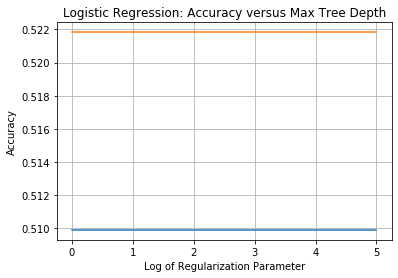

In [59]:
plt.figure()
plt.plot([np.log(c+1) for c in list(scores_lr.keys())], [scores_lr[md] for md in scores_lr])
plt.title('Logistic Regression: Accuracy versus Max Tree Depth')
plt.xlabel('Log of Regularization Parameter')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

### XGBoost

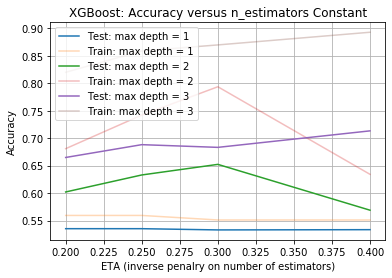

In [60]:
max_depths, ys = get_param_data(scores_xgb)

plt.figure()
for max_depth,dictionary in zip(max_depths,ys):
    plt.plot(list(dictionary.keys()), [dictionary[md][0] for md in dictionary], label='Test: max depth = '+str(max_depth))
    plt.plot(list(dictionary.keys()), [dictionary[md][1] for md in dictionary], label='Train: max depth = '+str(max_depth), alpha=0.3)
plt.title('XGBoost: Accuracy versus n_estimators Constant')
plt.xlabel('ETA (inverse penalry on number of estimators)')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid()
plt.show()

# Plot Predictions on S&P500 Data using Optimal Parameters

In [63]:
### make there be the same number of data points in each class
from sklearn.utils import resample
zero_data = all_data.loc[all_data['change_ind']==0]
one_data = all_data.loc[all_data['change_ind']==1]
n_samples = max(len(zero_data), len(one_data))
zero_data = resample(zero_data, replace=True, n_samples=n_samples)
one_data = resample(one_data, replace=True, n_samples=n_samples)
all_data = pd.concat([zero_data,one_data])

X_train, X_test, y_train, y_test = train_test_split(all_data.loc[:, all_data.columns != 'change_ind'], 
                                                     all_data.change_ind, test_size=0.3, 
                                                     random_state = 109, 
                                                     stratify = all_data.change_ind)
X_test = X_test.drop('index', axis = 1)
X_train = X_train.drop('index', axis = 1)

In [64]:
### Optimal Parameters for Random Forest
max_tree_depth_rf = 3
model_rf = rf(max_depth=max_tree_depth_rf).fit(X_train, y_train)
c_m_rf = confusion_matrix(y_test, model_rf.predict(X_test))

### Optimal Parameters for AdaBoost
max_tree_depth_adaboost = 1
n_estiators_adaboost = 3
model_ab = ab(base_estimator=DecisionTreeClassifier(max_depth=max_tree_depth_adaboost), n_estimators=n_estiators_adaboost).fit(X_train, y_train)
c_m_ab = confusion_matrix(y_test, model_ab.predict(X_test))

### Optimal Parameters for Neural Network
architecture_nn = [5, 5, 5]
model_nn = nn(hidden_layer_sizes=architecture_nn).fit(X_train, y_train)
c_m_nn = confusion_matrix(y_test, model_nn.predict(X_test))

### Optimal Parameters for Logistic Regression
c_lr = 1.0
model_lr = lr(C=c_lr, solver='lbfgs').fit(X_train, y_train)
c_m_lr = confusion_matrix(y_test, model_lr.predict(X_test))

### Optimal Parameters for XGBoost
max_depth_xgb = 1
eta_xgb = 0.2
param = {'max_depth': max_depth_xgb,'eta': eta_xgb,'silent': 1,'objective': 'multi:softprob','num_class': 2}
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
model_xgb = xgb.train(param, dtrain, 200, evals= [(dtrain, 'train')], early_stopping_rounds=4, verbose_eval=20)
preds = np.round(model_xgb.predict(dtest)[:,1]).astype(int)
c_m_xgb = confusion_matrix(y_test, preds)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-merror:0.482593
Will train until train-merror hasn't improved in 4 rounds.
[20]	train-merror:0.417965
[40]	train-merror:0.375841
[60]	train-merror:0.346605
[80]	train-merror:0.326217
Stopping. Best iteration:
[83]	train-merror:0.324678



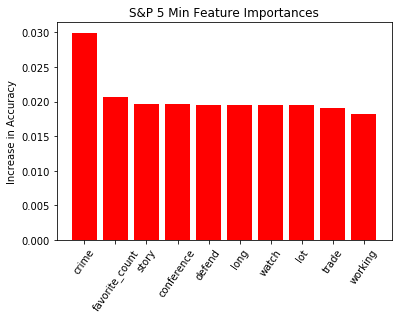

In [65]:
### plot feature importances (XGBoost)
n_features = 10

importances = model_xgb.get_score(importance_type='gain')
total_importance = sum([importances[key] for key in importances])
importances = [(feature,importance/total_importance) for feature,importance in sorted(zip([key for key in importances],[importances[key] for key in importances]), key = lambda x: x[1], reverse=True)][0:n_features]

# Plot the feature importances of the forest
plt.figure()
plt.title("S&P "+str(time_frame)+" Min Feature Importances")
plt.bar(range(n_features), [importance for x,importance in importances], color="r", align="center")
plt.xticks(range(n_features), [feature for feature,x in importances], rotation=55)
plt.ylabel('Increase in Accuracy')
plt.show()

<Figure size 432x288 with 0 Axes>

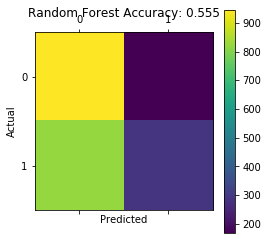

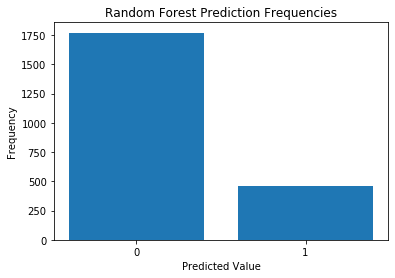

<Figure size 432x288 with 0 Axes>

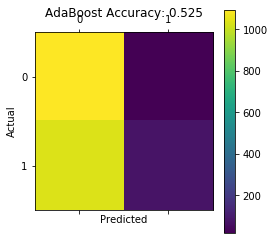

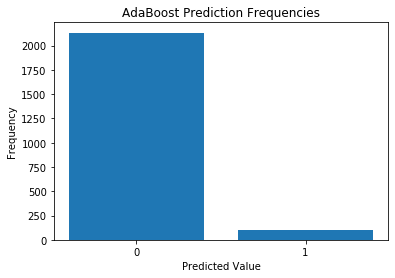

<Figure size 432x288 with 0 Axes>

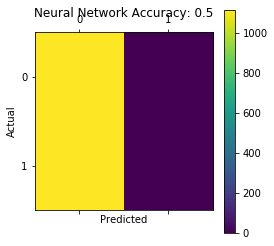

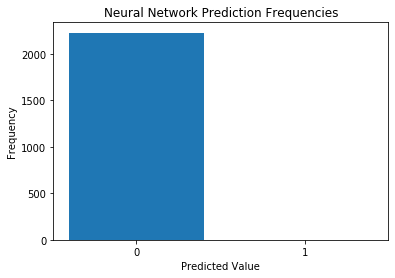

<Figure size 432x288 with 0 Axes>

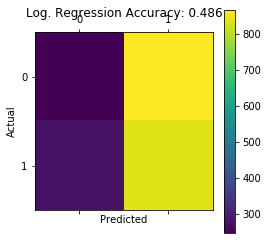

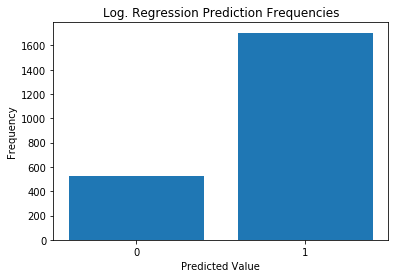

<Figure size 432x288 with 0 Axes>

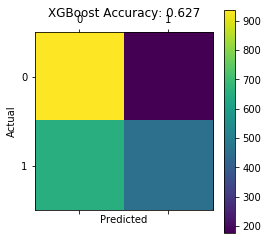

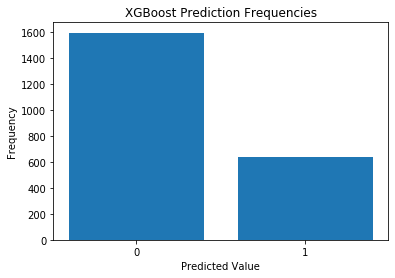

In [66]:
### Plot Barplot of predictions and confusion matrices

plt.figure()
plt.matshow(c_m_rf)
plt.title('Random Forest Accuracy: '+str(round((c_m_rf[0,0]+c_m_rf[1,1])/sum(sum(c_m_rf)),3)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()
plt.figure()
plt.bar([0,1],[sum(c_m_rf[:,0]),sum(c_m_rf[:,1])])
plt.title('Random Forest Prediction Frequencies')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.xticks([0,1])
plt.show()

plt.figure()
plt.matshow(c_m_ab)
plt.title('AdaBoost Accuracy: '+str(round((c_m_ab[0,0]+c_m_ab[1,1])/sum(sum(c_m_ab)),3)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()
plt.figure()
plt.bar([0,1],[sum(c_m_ab[:,0]),sum(c_m_ab[:,1])])
plt.title('AdaBoost Prediction Frequencies')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.xticks([0,1])
plt.show()

plt.figure()
plt.matshow(c_m_nn)
plt.title('Neural Network Accuracy: '+str(round((c_m_nn[0,0]+c_m_nn[1,1])/sum(sum(c_m_nn)),3)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()
plt.figure()
plt.bar([0,1],[sum(c_m_nn[:,0]),sum(c_m_nn[:,1])])
plt.title('Neural Network Prediction Frequencies')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.xticks([0,1])
plt.show()

plt.figure()
plt.matshow(c_m_lr)
plt.title('Log. Regression Accuracy: '+str(round((c_m_lr[0,0]+c_m_lr[1,1])/sum(sum(c_m_lr)),3)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()
plt.figure()
plt.bar([0,1],[sum(c_m_lr[:,0]),sum(c_m_lr[:,1])])
plt.title('Log. Regression Prediction Frequencies')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.xticks([0,1])
plt.show()

plt.figure()
plt.matshow(c_m_xgb)
plt.title('XGBoost Accuracy: '+str(round((c_m_xgb[0,0]+c_m_xgb[1,1])/sum(sum(c_m_xgb)),3)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()
plt.figure()
plt.bar([0,1],[sum(c_m_xgb[:,0]),sum(c_m_xgb[:,1])])
plt.title('XGBoost Prediction Frequencies')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.xticks([0,1])
plt.show()

# Regression

In [67]:
tweets_sp_df = trump_sp_df_timeframe(1)

v_all = TfidfVectorizer()
X_all = v_all.fit_transform(tweets_sp_df['text'])
df_tfidf_all = pd.DataFrame(X_all.toarray(), columns=v_all.get_feature_names())
tweets_all_subset = tweets_sp_df[['retweet_count', 'favorite_count']]
all_data = pd.concat([tweets_all_subset.reset_index(), df_tfidf_all], axis=1)

all_data['perc_change'] = tweets_sp_df['perc_change'].tolist()
all_data = all_data.drop('index', axis = 1)
all_data = all_data.dropna()

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(all_data.loc[:, all_data.columns != 'perc_change'], 
                                                     all_data.perc_change, test_size=0.3, 
                                                     random_state = 109)

dmatrix_train = xgb.DMatrix(data=X_train_all,label=y_train_all)
dmatrix_test = xgb.DMatrix(data=X_test_all,label=y_test_all)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [68]:
### Random Forest Regression
from  sklearn.ensemble import RandomForestRegressor as rf_reg

max_depths = [1,2,3,5,10,25,35,50,75,100,150,200]
scores_rf_reg = dict()

for max_depth in max_depths:
    print('Testing Max Depth',max_depth,end='')
    start = time.time()
    kf = KFold(n_splits=5)
    
    accuracies = list()
    for train_index, test_index in kf.split(X_train_all):
        rf_model_all = rf_reg(n_estimators=100, max_depth=max_depth, max_features = 'sqrt').fit(X_train_all.values[train_index], y_train_all.values[train_index])
        preds = rf_model_all.predict(X_train_all.values[test_index])
        random_forest_test_score_all = np.mean((y_train_all.values[test_index] - preds)**2)
        accuracies.append(random_forest_test_score_all)
    scores_rf_reg[max_depth] = np.mean(accuracies)
    print(' ...',round(time.time()-start,1),'seconds elapsed\tScore:',round(np.mean(accuracies),3))

Testing Max Depth 1 ... 5.7 seconds elapsed	Score: 0.0
Testing Max Depth 2 ... 5.6 seconds elapsed	Score: 0.0
Testing Max Depth 3 ... 6.0 seconds elapsed	Score: 0.0
Testing Max Depth 5 ... 5.3 seconds elapsed	Score: 0.0
Testing Max Depth 10 ... 5.7 seconds elapsed	Score: 0.0
Testing Max Depth 25 ... 5.2 seconds elapsed	Score: 0.0
Testing Max Depth 35 ... 4.9 seconds elapsed	Score: 0.0
Testing Max Depth 50 ... 5.0 seconds elapsed	Score: 0.0
Testing Max Depth 75 ... 4.9 seconds elapsed	Score: 0.0
Testing Max Depth 100 ... 4.8 seconds elapsed	Score: 0.0
Testing Max Depth 150 ... 4.8 seconds elapsed	Score: 0.0
Testing Max Depth 200 ... 4.8 seconds elapsed	Score: 0.0


In [69]:
for max_depth in scores_rf_reg:
    print(max_depth,':\t', scores_rf_reg[max_depth])

1 :	 6.32522483063208e-08
2 :	 6.324391491722862e-08
3 :	 6.324891966558688e-08
5 :	 6.32460515775199e-08
10 :	 6.324928210304783e-08
25 :	 6.324876056600405e-08
35 :	 6.324590990012624e-08
50 :	 6.324945792486498e-08
75 :	 6.324978701591148e-08
100 :	 6.324451892561843e-08
150 :	 6.324498960858983e-08
200 :	 6.325055424309149e-08


In [70]:
### Train on full training set and predict on test set, reporting accuracy

model_rf_reg = rf_reg(n_estimators=75, max_depth=100, max_features = 'sqrt').fit(X_train_all, y_train_all)
preds = model_rf_reg.predict(X_test_all)

baseline_mse = np.mean((y_test_all.values-np.mean(y_train_all.values))**2)
rf_mse = np.mean((preds - y_test_all)**2)

print('Baseline prediction MSE:',baseline_mse)
print('Random forest prediction MSE:',rf_mse)

Baseline prediction MSE: 7.65452945855667e-08
Random forest prediction MSE: 7.65602169847843e-08


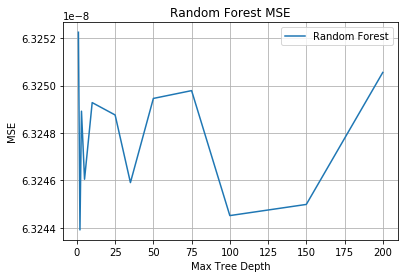

In [71]:
### Plot mse versus max tree depth

plt.figure()
plt.plot([key for key in scores_rf_reg.keys()], [scores_rf_reg[key] for key in scores_rf_reg], label='Random Forest')
# plt.axhline(y=baseline_mse, label='Predicting Mean (Baseline)')
plt.xlabel('Max Tree Depth')
plt.ylabel('MSE')
plt.title('Random Forest MSE')
plt.legend()
plt.grid()
plt.show()

# EDA

In [77]:
vix_df = pd.read_csv("tf_data/CS109aProjectVIXData.csv")
split_df = vix_df['Date'].str.split(" ", n = 1, expand = True)
vix_df['Date'] = split_df[0]
vix_df['Time'] = split_df[1]

vix_df['Date'] = pd.to_datetime(vix_df['Date'])
vix_df['Date'] = list(map(lambda x : str(x)[5:7] + "/" + str(x)[8:10] + "/" + str(x)[:4], vix_df['Date'].dt.date.tolist()))
vix_df['Time'] = pd.to_datetime(vix_df['Time'])
vix_df['Time'] = list(map(lambda x : str(x)[:5], vix_df['Time'].dt.time.tolist()))
vix_df.head()

,Date,Last Price,Time
0,12/01/2015,15.66,09:31
1,12/01/2015,15.64,09:32
2,12/01/2015,15.61,09:33
3,12/01/2015,15.63,09:34
4,12/01/2015,15.75,09:35


In [78]:
# reconcile S&P and Trump tweets datasets by date and time
trump_tweets_df_biz_vix = trump_tweets_df[trump_tweets_df['date'].isin(vix_df['Date'])]
trump_tweets_df_biz_vix = trump_tweets_df_biz_vix[trump_tweets_df_biz_vix['time_stamp'].isin(vix_df['Time'])]

# merging S&P and Trump tweets datasets
tweets_vix_df = pd.merge(trump_tweets_df_biz_vix, vix_df,  how='left', left_on=['date','time_stamp'], 
                  right_on = ['Date','Time']).dropna()

def get_perc_change_after_time_vix(num_minutes_after_tweet):
    import datetime
    
    next_min_list = list(map(lambda x: str((datetime.datetime.combine(datetime.date(1, 1, 1), x) + datetime.timedelta(minutes=num_minutes_after_tweet)).time())[:5], 
                             tweets_vix_df['created_at'].dt.time.tolist()))
#     print(next_min_list)
    curr_min_list = tweets_vix_df['Time']
    date_list = tweets_vix_df['Date'].tolist()
    
    spliced_min = [None]*(len(next_min_list)+len(curr_min_list))
    spliced_min[::2] = curr_min_list
    spliced_min[1::2] = next_min_list

    spliced_date = [None]*(len(date_list)+len(date_list))
    spliced_date[::2] = date_list
    spliced_date[1::2] = date_list
    
    df_dict = {}
    df_dict['date'] = spliced_date
    df_dict['time'] = spliced_min
    
    spliced_df = pd.DataFrame(df_dict)
    
    spliced_merge = pd.merge(spliced_df, vix_df,  how='left', left_on=['date','time'], 
                  right_on = ['Date','Time'])
    
    perc_change_list = spliced_merge['Last Price'].pct_change().tolist()[1:][::2]
    
    return perc_change_list

def trump_vix_df_timeframe(num_minutes_after_tweet):
    tweets_vix_df['perc_change'] = get_perc_change_after_time_vix(num_minutes_after_tweet)
    change_ind_list = []
    for change in get_perc_change_after_time_vix(num_minutes_after_tweet):
        if change == 0.0:
            change_ind_list.append(0)
        elif change > 0.0:
            change_ind_list.append(1)
        else:
            change_ind_list.append(-1)
    tweets_vix_df['change_ind'] = change_ind_list
#     tweets_vix_df['change_ind'] = list(map(lambda x: 1 if x >= 0 else 0, get_perc_change_after_time_vix(num_minutes_after_tweet)))
    return tweets_vix_df

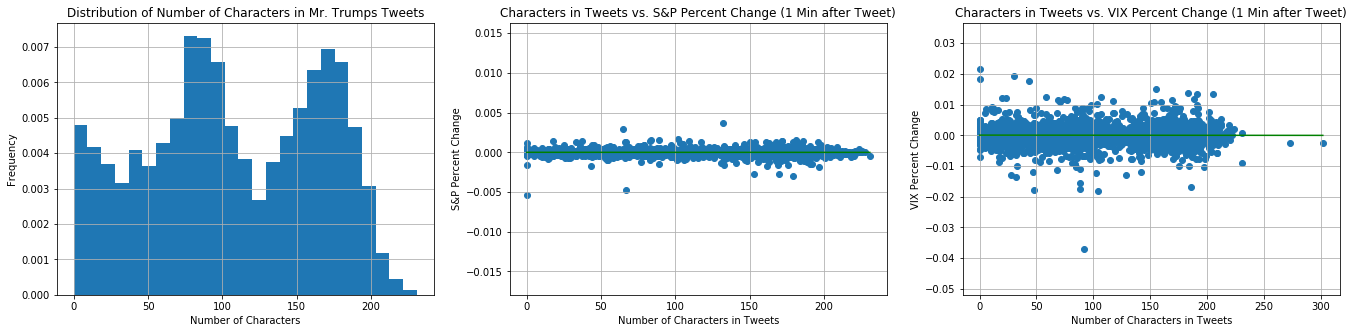

In [79]:
length_tweets_sp = list(map(lambda x: len(x), trump_sp_df_timeframe(1)['text'].tolist()))
del length_tweets_sp[length_tweets_sp.index(max(length_tweets_sp))]

perc_change_sp = trump_sp_df_timeframe(1)['perc_change']
del perc_change_sp[length_tweets_sp.index(max(length_tweets_sp))]

length_tweets_vix = list(map(lambda x: len(x), trump_vix_df_timeframe(1)['text'].tolist()))
del length_tweets_vix[length_tweets_vix.index(max(length_tweets_vix))]

perc_change_vix = trump_vix_df_timeframe(1)['perc_change']
del perc_change_vix[length_tweets_vix.index(max(length_tweets_vix))]

plt.figure(figsize=(23,5))

plt.subplot(1,3,1)
plt.hist(length_tweets_sp, bins = 25, density=True)
plt.title('Distribution of Number of Characters in Mr. Trumps Tweets')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.grid()

plt.subplot(1,3,2)
plt.scatter(length_tweets_sp, perc_change_sp)
plt.plot(np.unique(length_tweets_sp), np.poly1d(np.polyfit(length_tweets_sp, perc_change_sp, 1))(np.unique(length_tweets_sp)), color='green')
plt.title('Characters in Tweets vs. S&P Percent Change (1 Min after Tweet)')
plt.xlabel('Number of Characters in Tweets')
plt.ylabel('S&P Percent Change')
plt.grid()

plt.subplot(1,3,3)
plt.scatter(length_tweets_vix, perc_change_vix)
plt.plot(np.unique(length_tweets_vix), np.poly1d(np.polyfit(length_tweets_vix, perc_change_vix, 1))(np.unique(length_tweets_vix)), color='green')
plt.title('Characters in Tweets vs. VIX Percent Change (1 Min after Tweet)')
plt.xlabel('Number of Characters in Tweets')
plt.ylabel('VIX Percent Change')
plt.grid()
plt.show()

# S&P Time Series

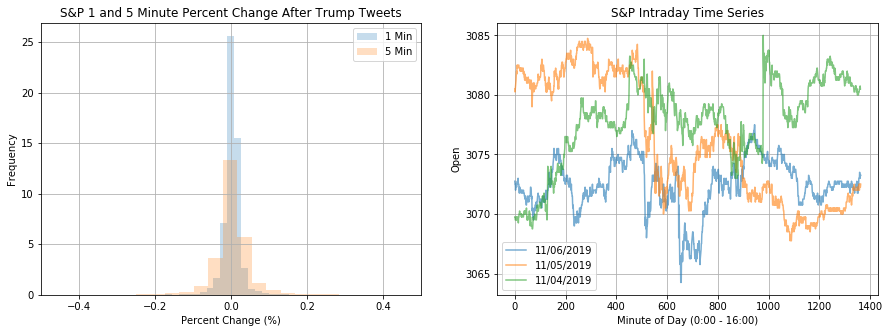

In [80]:
perc_change_1 = trump_sp_df_timeframe(1)['perc_change'].values.tolist()
perc_change_5 = trump_sp_df_timeframe(5)['perc_change'].values.tolist()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(list(map(lambda x: 100*x, perc_change_1)), bins=50, density=True, alpha=0.25, label='1 Min')
plt.hist(list(map(lambda x: 100*x, perc_change_5)), bins=50, density=True, alpha=0.25, label='5 Min')
plt.title('S&P 1 and 5 Minute Percent Change After Trump Tweets')
plt.xlabel('Percent Change (%)')
plt.xlim((-0.5, 0.5))
plt.ylabel('Frequency')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(len(sp_df[sp_df['Date'] == '11/06/2019']['Open'])), 
         sp_df[sp_df['Date'] == '11/06/2019']['Open'], "-", label = '11/06/2019', alpha = 0.6)
plt.plot(range(len(sp_df[sp_df['Date'] == '11/05/2019']['Open'])), 
         sp_df[sp_df['Date'] == '11/05/2019']['Open'], "-", label = '11/05/2019', alpha = 0.6)
plt.plot(range(len(sp_df[sp_df['Date'] == '11/04/2019']['Open'])), 
         sp_df[sp_df['Date'] == '11/04/2019']['Open'], "-", label = '11/04/2019', alpha = 0.6)
plt.title('S&P Intraday Time Series')
plt.xlabel('Minute of Day (0:00 - 16:00)')
plt.ylabel('Open')
plt.legend()
plt.grid()
plt.show()

# VIX Time Series

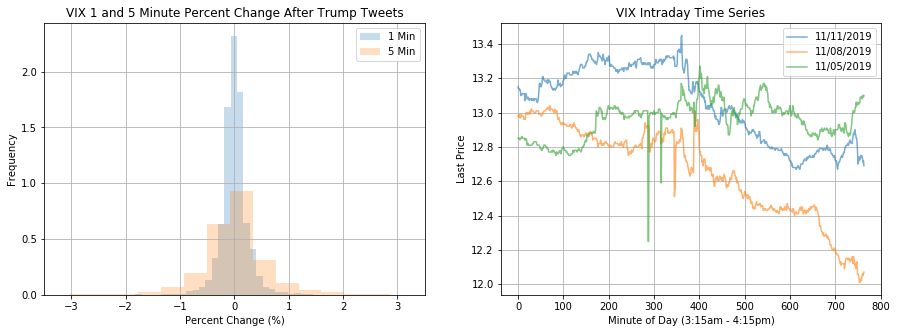

In [81]:
perc_change_1 = trump_vix_df_timeframe(1)['perc_change'].values.tolist()
perc_change_5 = trump_vix_df_timeframe(5)['perc_change'].values.tolist()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(list(map(lambda x: 100*x, perc_change_1)), bins=50, density=True, alpha=0.25, label='1 Min')
plt.hist(list(map(lambda x: 100*x, perc_change_5)), bins=50, density=True, alpha=0.25, label='5 Min')
plt.title('VIX 1 and 5 Minute Percent Change After Trump Tweets')
plt.xlabel('Percent Change (%)')
plt.xlim((-3.5, 3.5))
plt.ylabel('Frequency')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(len(vix_df[vix_df['Date'] == '11/11/2019']['Last Price'])), 
         vix_df[vix_df['Date'] == '11/11/2019']['Last Price'], "-", label = '11/11/2019', alpha = 0.6)
plt.plot(range(len(vix_df[vix_df['Date'] == '11/08/2019']['Last Price'])), 
         vix_df[vix_df['Date'] == '11/08/2019']['Last Price'], "-", label = '11/08/2019', alpha = 0.6)
plt.plot(range(len(vix_df[vix_df['Date'] == '11/05/2019']['Last Price'])), 
         vix_df[vix_df['Date'] == '11/05/2019']['Last Price'], "-", label = '11/05/2019', alpha = 0.6)
plt.title('VIX Intraday Time Series')
plt.xlabel('Minute of Day (3:15am - 4:15pm)')
plt.ylabel('Last Price')
plt.legend()
plt.grid()
plt.show()

# Most Common Words

In [82]:
pop_wrds_t = (tweets_vix_df["text"].apply(lambda x : 
                                         pd.value_counts(x.split(" ")))
            .sum(axis = 0).reset_index().sort_values(by = [0],ascending = True))
pop_wrds_t.columns = ["word","count"]
pop_wrds_t["word"] = pop_wrds_t["word"].str.upper()

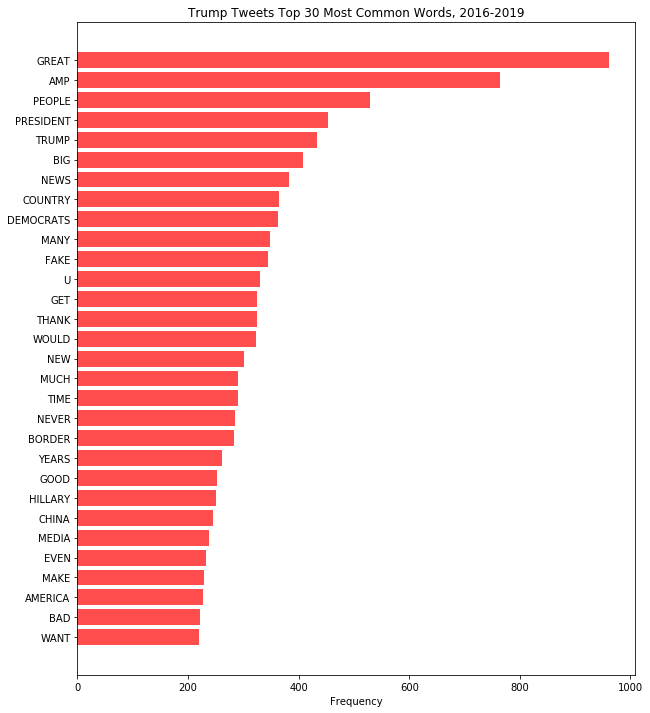

In [83]:
pos = np.arange(len(pop_wrds_t["count"][-30:])) + .5

#Plot
plt.figure(figsize=(10,12))
plt.barh(pos, pop_wrds_t["count"][-30:], align='center', color = 'red', alpha = 0.7)
plt.yticks(pos, pop_wrds_t["word"][-30:])
plt.xlabel('Frequency')
plt.title('Trump Tweets Top 30 Most Common Words, 2016-2019')
plt.show()

# Word2Vec Embedding

In [84]:
! pip install gensim

In [85]:
import gensim 
from gensim.models import Word2Vec 

list_all_words = list(map(lambda x: x.split(), tweets_sp_df['text'].tolist()))
model1 = gensim.models.Word2Vec(list_all_words, min_count = 20,  
                              size = 300, window = 50, sg = 1) 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


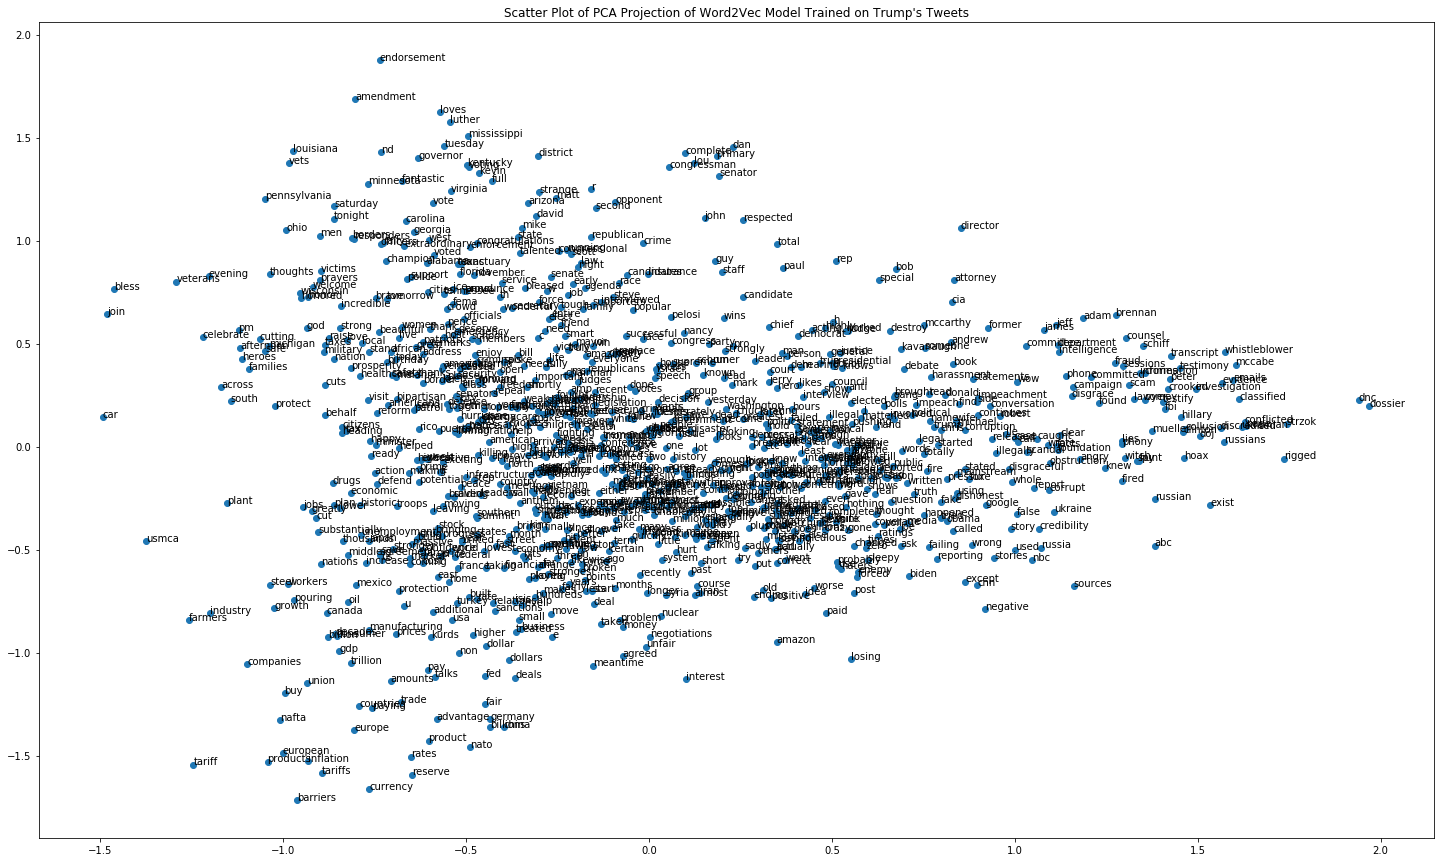

In [86]:
from sklearn.decomposition import PCA

X = model1[model1.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize = (25,15))
plt.scatter(result[:, 0], result[:, 1])
words = list(model1.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.title("Scatter Plot of PCA Projection of Word2Vec Model Trained on Trump's Tweets")
plt.show()